## Introduction to Supervised Machine Learning
**Instructor:** Lisa-Marie Rolli, Volkamer Lab, Saarland University (lisa-marie.rolli@uni-saarland.de)


**Workshop date:** 13th January 2026

**Further reading**: A gentle introduction into statistical learning with Python or R can be found in the textbook ["An introduction to statistical learning" by James et al.](https://www.statlearning.com/).

Machine learning (ML) is a research area in computer science, where algorithms are developed to learn from data. Generally, ML can be subdivided into four major realms: (i) supervised learning, (ii) unsupervised learning, (iii) semi-supervised learning, and (iv) reinforcement learning. In this notebook, we focus on supervised ML. In supervised ML, an algorithm learns to predict a specific *response* (e.g., toxicity) for a sample (e.g., compound) based on *features* of the sample (e.g., physicochemical propteries). The learning is based on the assumption that there is a functional relationship between the features and the response, which we can approximate. There exist a plethora of different algorithms, which mainly differ in their assumptions about the true relationship and their learning algorithm, i.e., how they approximate the true function. In this tutorial we will start with linear regression, which assumes a linear relationship between the features and the response.

### Data
As mentioned above, the dataset must consist of *features*, i.e., descriptors of the samples, and a *response*, i.e., a measurement that we want to predict. The goal is to learn a relationship between the features and the response for a given *training set* of samples so that we can later predict for *unseen* samples. In particular, we always separate a hold out *test set*, which is used to evaluate how well our model predicts for samples that it has not seen during training.

The most important step in the ML pipeline is the data processing. In the following, we first download the [AqSolDB dataset](https://doi.org/10.1038/s41597-019-0151-1) from our GitHub, as this is our toy dataset for this tutorial.

In [1]:
import sys

IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    !pip install rdkit
    !pip install datasail
    !wget https://raw.githubusercontent.com/volkamerlab/Programming4RADAR/refs/heads/main/Example_Data/solubility_values.tsv
    !wget https://raw.githubusercontent.com/volkamerlab/Programming4RADAR/refs/heads/main/Example_Data/smiles.tsv

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from datasail.sail import datasail
from sklearn.metrics import r2_score, mean_absolute_error
from rdkit import Chem, RDLogger 
from rdkit.Chem import Draw, Descriptors, rdMolDescriptors
from rdkit.Chem import PandasTools
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
RDLogger.DisableLog('rdApp.*')

C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality


In [3]:
if not IN_COLAB:
    smiles_df = pd.read_csv('Example_Data/smiles.tsv', sep = '\t', index_col = 0)
else:
    smiles_df = pd.read_csv('smiles.tsv', sep = '\t', index_col = 0)
smiles_df.head()

,SMILES
compound_id,
817354021,[Br-].CCCCCCCCCCCCCCCCCC[N+](C)(C)C
884077896,O=C1Nc2cccc3cccc1c23
100491263,Clc1ccc(C=O)cc1
650290313,[Zn++].CC(c1ccccc1)c2cc(C(C)c3ccccc3)c(O)c(c2)...
324766667,C1OC1CN(CC2CO2)c3ccc(Cc4ccc(cc4)N(CC5CO5)CC6CO...


Most ML models are not able to directly process text, e.g., SMILES strings. Therefore, we calculate numerical descriptors that are easier for the model to understand. One of the most simple representations are physicochemical properties that we can calculate using RDKit. RDKit is a library that can (among other things) read SMILES and store them as a molecule:

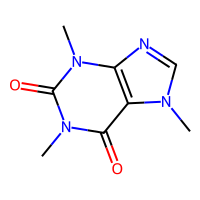

In [4]:
smiles_caffeine = "CN1C=NC2=C1C(=O)N(C(=O)N2C)C"
caffeine = Chem.MolFromSmiles(smiles_caffeine)
Draw.MolsToImage([caffeine])


After reading the SMILES, we can also caluclate different physiochemical properties of the molcule:

In [5]:
print(f"MolWt: {Descriptors.MolWt(caffeine)}")
print(f"logP: {Descriptors.MolLogP(caffeine)}")
print(f"Num HBA: {rdMolDescriptors.CalcNumHBA(caffeine)}")
print(f"Num HBD: {rdMolDescriptors.CalcNumHBD(caffeine)}")
print(f"Num rotable bonds (RB): {rdMolDescriptors.CalcNumRotatableBonds(caffeine)}")

MolWt: 194.194
logP: -1.0293
Num HBA: 6
Num HBD: 0
Num rotable bonds (RB): 0


Now, we want to calculate the LogP for all molecules in our ```smiles_df``` data frame, as we think, it should have some predictive information that can be leveraged when prediciting solubility. First, we convert all SMILES strings in our dataframe to molecules.

In [6]:
# ensure that molecules are displayed in dataframe
PandasTools.RenderImagesInAllColumns = True

PandasTools.AddMoleculeColumnToFrame(smiles_df, "SMILES", molCol='molecule')
smiles_df.dropna(inplace = True)
smiles_df

Failed to patch pandas - unable to change molecule rendering


,SMILES,molecule
compound_id,,
817354021,[Br-].CCCCCCCCCCCCCCCCCC[N+](C)(C)C,<rdkit.Chem.rdchem.Mol object at 0x00000152D70...
884077896,O=C1Nc2cccc3cccc1c23,<rdkit.Chem.rdchem.Mol object at 0x00000152D70...
100491263,Clc1ccc(C=O)cc1,<rdkit.Chem.rdchem.Mol object at 0x00000152D70...
650290313,[Zn++].CC(c1ccccc1)c2cc(C(C)c3ccccc3)c(O)c(c2)...,<rdkit.Chem.rdchem.Mol object at 0x00000152D70...
324766667,C1OC1CN(CC2CO2)c3ccc(Cc4ccc(cc4)N(CC5CO5)CC6CO...,<rdkit.Chem.rdchem.Mol object at 0x00000152D70...
...,...,...
624359319,C(c1ccc(cc1)NCCCC)(=O)OCCN(C)C,<rdkit.Chem.rdchem.Mol object at 0x00000152D71...
215150761,OC1=C(C(C2=C(O)[C@@](C(C(C(N)=O)=C(O)[C@H]3N(C...,<rdkit.Chem.rdchem.Mol object at 0x00000152D71...
259287587,c1(cc(ccc1C(C)C)C)O,<rdkit.Chem.rdchem.Mol object at 0x00000152D71...


Then, we calculate the LogP for all molecules in the dataframe. If we were not able to calculate the LogP for any of the comounds, we remove it, because we don't have a descriptor that we could use for our prediction.

In [7]:
smiles_df["logp"] = smiles_df["molecule"].apply(Descriptors.MolLogP)
# if we have missing values, we remove the molecules
smiles_df.dropna(inplace=True)
smiles_df

,SMILES,molecule,logp
compound_id,,,
817354021,[Br-].CCCCCCCCCCCCCCCCCC[N+](C)(C)C,<rdkit.Chem.rdchem.Mol object at 0x00000152D70...,3.95810
884077896,O=C1Nc2cccc3cccc1c23,<rdkit.Chem.rdchem.Mol object at 0x00000152D70...,2.40550
100491263,Clc1ccc(C=O)cc1,<rdkit.Chem.rdchem.Mol object at 0x00000152D70...,2.15250
650290313,[Zn++].CC(c1ccccc1)c2cc(C(C)c3ccccc3)c(O)c(c2)...,<rdkit.Chem.rdchem.Mol object at 0x00000152D70...,8.11610
324766667,C1OC1CN(CC2CO2)c3ccc(Cc4ccc(cc4)N(CC5CO5)CC6CO...,<rdkit.Chem.rdchem.Mol object at 0x00000152D70...,2.48540
...,...,...,...
624359319,C(c1ccc(cc1)NCCCC)(=O)OCCN(C)C,<rdkit.Chem.rdchem.Mol object at 0x00000152D71...,2.61700
215150761,OC1=C(C(C2=C(O)[C@@](C(C(C(N)=O)=C(O)[C@H]3N(C...,<rdkit.Chem.rdchem.Mol object at 0x00000152D71...,-0.21440
259287587,c1(cc(ccc1C(C)C)C)O,<rdkit.Chem.rdchem.Mol object at 0x00000152D71...,2.82402


Now, we load the target, i.e., the continuous solubility values LogS, that we want to predict.

In [8]:
if not IN_COLAB:
    response_df = pd.read_csv('Example_Data/solubility_values.tsv', sep = '\t', index_col = 0)
else:
    response_df = pd.read_csv('solubility_values.tsv', sep = '\t', index_col = 0)
response_df.head()

,LogS
compound_id,
817354021,-3.616127
884077896,-3.254767
100491263,-2.177078
650290313,-3.924409
324766667,-4.662065


As not all molecules are necessarily tested in all assays, we now only take the intersection of molecules with available properties and response.

In [9]:
considered_mols = list(set(smiles_df.index).intersection(set(response_df.index)))
X = smiles_df.loc[considered_mols, ['logp']]
y = response_df.loc[considered_mols]
print(f'We have {len(considered_mols)} molecules in our dataset.')

We have 9982 molecules in our dataset.


Now, we can have a look at the response plotted with respect to the different features (physicochemical properties) that we calculated before:

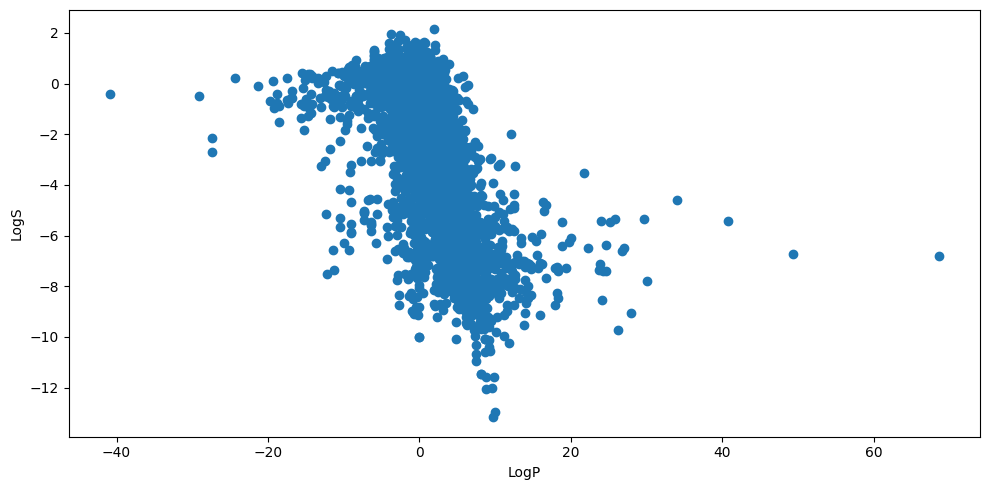

In [10]:
fig, ax = plt.subplots(ncols=len(X.columns), figsize=(10, 5), sharex=False, sharey=True)


ax.scatter(X, y)
ax.set(xlabel='LogP')
ax.set(ylabel="LogS")
# Optional: add a little padding so points on the edge aren’t cut off


plt.tight_layout()
plt.show()



## Train and Test Set
As already mentioned above, we need two disjoint sets for training and for testing. Typically, the training set accounts for ~80% of the original dataset, while the remaining 20% are used for testing. The most easy way to split the data is to split the compounds randomly. However, as we want the model to generalize well across the chemical space, we make sure that similar compounds will be in the same set. To this end, we use a software called [`datasail`](https://datasail.readthedocs.io/en/latest/) that calculates the distance between the molecular fingerprints and splits the data so that the distance between the two sets is maximized.

In [11]:
e_splits, _, _ = datasail(
    techniques=["C1e"],
    splits=[8, 2],
    names=["train", "test"],
    runs=3,
    solver="SCIP",
    e_type="M",
    e_data=dict(zip(smiles_df.index, smiles_df["SMILES"].values.tolist())),
)
split = e_splits['C1e'][0]

                                     CVXPY                                     
                                     v1.5.3                                    
(CVXPY) Jan 12 04:39:49 PM: Your problem has 49 variables, 50 constraints, and 0 parameters.


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\cvxpy\problems\problem.py:158: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "


(CVXPY) Jan 12 04:39:50 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jan 12 04:39:50 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jan 12 04:39:50 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jan 12 04:39:50 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jan 12 04:39:50 PM: Compiling problem (target solver=SCIP).
(CVXPY) Jan 12 04:39:50 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> SCIP
(CVXPY) Jan 12 04:39:50 PM: Applying reduction Dcp2Cone
(CVXPY) Jan 12 04:39:50 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jan 12 04:39:50 PM: Applying

Now, we use the datasail output to split our features and responses into train and test.

In [12]:
train_samples = []
test_samples = []

for sample in split.keys():
    if split[sample] == 'train':
        train_samples.append(sample)
    else:
        test_samples.append(sample)

X_train = X.loc[train_samples, :]
X_test = X.loc[test_samples, :]
y_train = y.loc[train_samples, :]
y_test = y.loc[test_samples, :]

And we plot the train and test distribution for our feature (LogP) and response (LogS.)

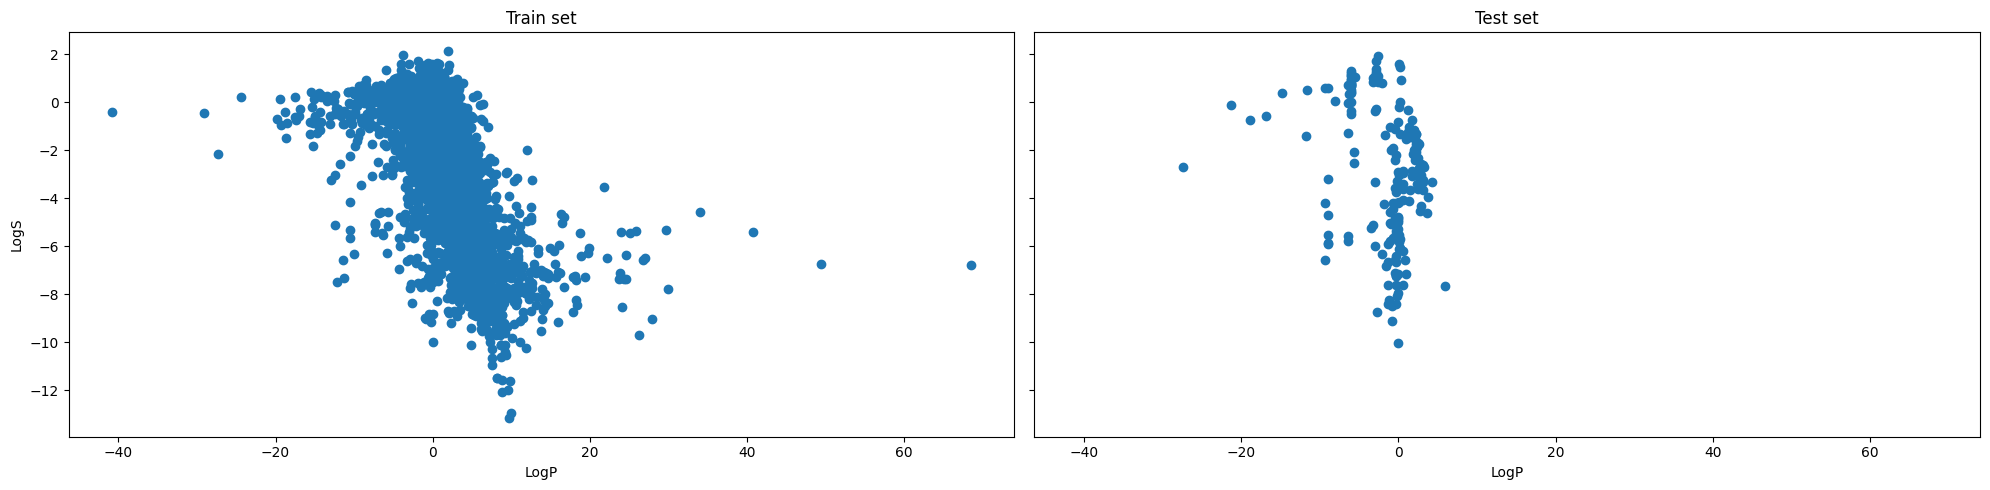

In [13]:
fig, ax = plt.subplots(ncols=2, figsize=(20, 5), sharex='row', sharey=True)


ax[0].scatter(X_train, y_train, label = 'Train set')
ax[0].set(xlabel='LogP', ylabel = 'LogS')
ax[1].scatter(X_test, y_test, label="Test set")
ax[1].set(xlabel='LogP')
ax[0].set(title = 'Train set')
ax[1].set(title = 'Test set')
plt.tight_layout()
plt.show()

## Model Training
We fit on the training set and predict on the test set. For the fit, we use *least square regression*.

In [14]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

The least square regression calculates the squared difference between all training datapoints and the current line (the prediction) and adjusts the slope and intercept of the line so that the difference between actual datapoints and prediction is minimized.

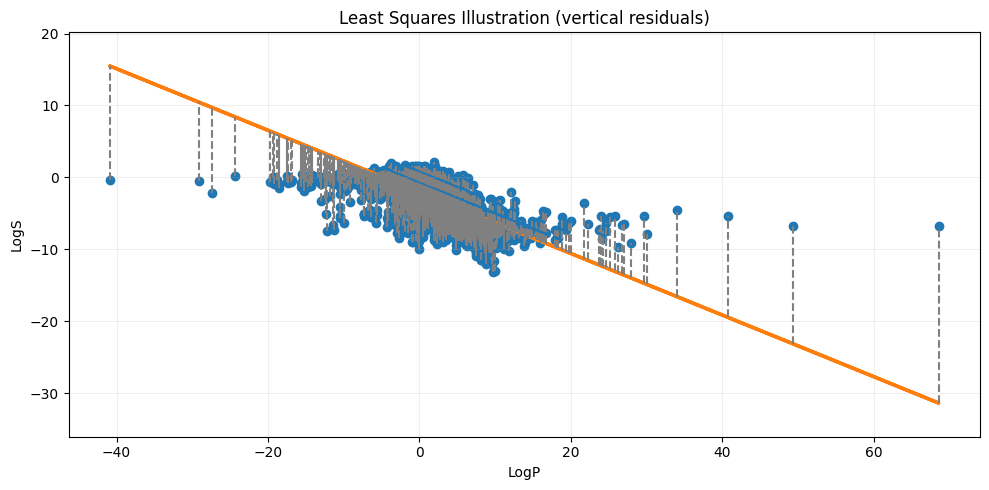

In [15]:
fig, ax = plt.subplots(figsize=(10, 5))

# Scatter points
ax.scatter(X_train, y_train, label="Training points")

train_prediction = regressor.predict(X_train)
# Regression line
ax.plot(X_train, train_prediction, color="tab:orange", lw=2.5)

# Residuals: vertical segments from each point to the line at the same x
for xi, yi, yhi in zip(X_train.values, y_train.values, train_prediction):
    ax.vlines(xi, ymin=min(yi, yhi), ymax=max(yi, yhi),
                color="gray", linestyle="--", lw=1.5)


# Formatting
ax.set_xlabel("LogP")
ax.set_ylabel("LogS")
title = "Least Squares Illustration (vertical residuals)"

ax.set_title(title)
ax.margins(x=0.05, y=0.1)
ax.grid(True, alpha=0.2)

plt.tight_layout()
plt.show()


After fitting the regression line, we can use it to predict for any new data point in our test set:

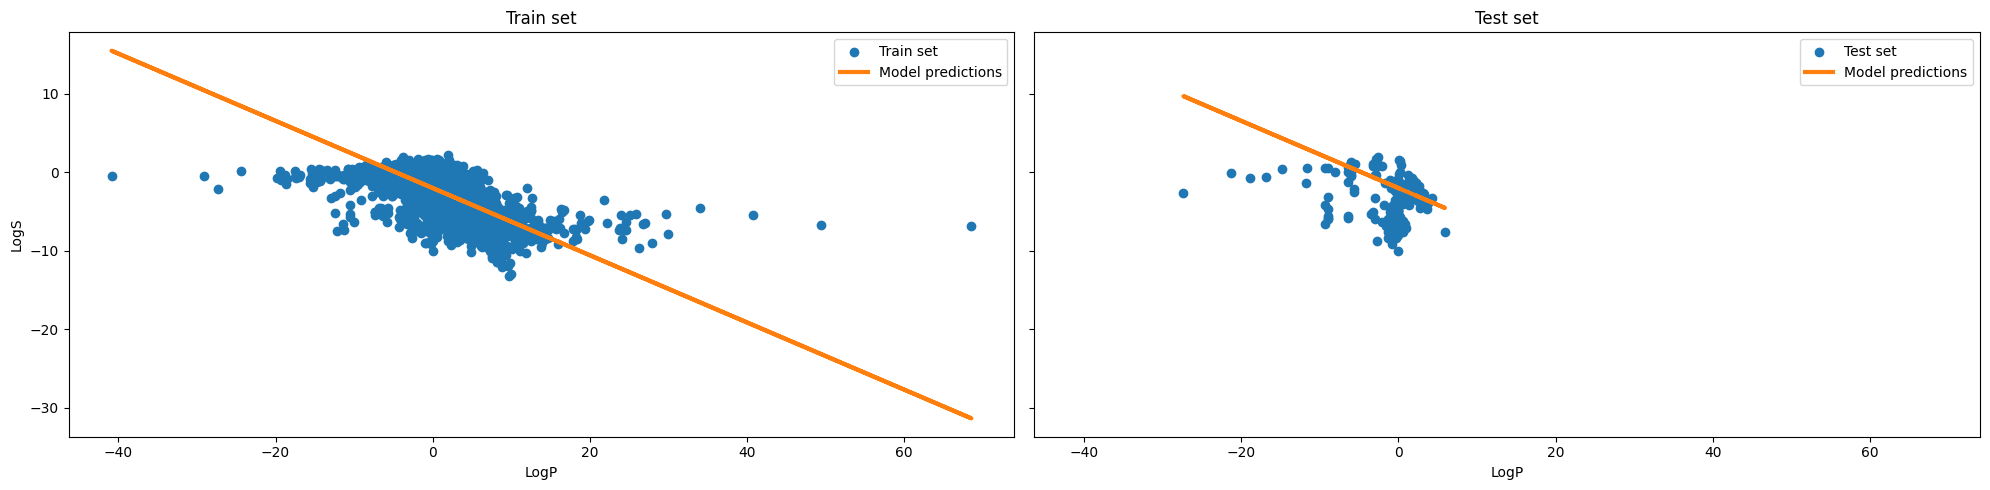

In [16]:
fig, ax = plt.subplots(ncols=2,  figsize=(20,5), sharex='row', sharey=True)


ax[0].scatter(X_train, y_train, label = 'Train set')
ax[0].set(xlabel='LogP', ylabel = 'LogS')
ax[0].plot(X_train,regressor.predict(X_train),linewidth=3,color="tab:orange", label="Model predictions")
ax[1].scatter(X_test, y_test, label="Test set")
ax[1].set(xlabel='LogP')
ax[1].plot(X_test, y_pred, linewidth=3, color="tab:orange", label="Model predictions")

ax[0].set(title = 'Train set')
ax[1].set(title = 'Test set')
ax[0].legend()
ax[1].legend()
plt.tight_layout()
plt.show()

## Performance Evaluation
From looking at this plot, we can guess that this model does not predict really well. To quantify how good/bad a model *performs*, we use performance metrics such as the mean absolute error (MAE), which tells us how much our prediction $\hat{y}_i$ for a sample $i$ differs from the true value $y_i$ averaged over the number of samples $n$:

$MAE = \frac{1}{n} \cdot \sum_{i = 1}^{n}\vert \hat{y}_i - y_i\vert$

The value is in the same unit as the response (in our case the LogS). Thus, the judgement on whether the observed value is good or bad depends on the dataset. Another metric that is easier to interpret is the *coefficient of determination ($R^2$)*. It is a value in $(-\inf, 1]$, which tells you whether your model was better ($>0$) or worse ($<0$) than simply predicting the mean $\bar{y}$ of the test set.

$R^2 = \frac{\sum_{i = 1}^{n} (\hat{y}_i - y_i)^2}{\sum_{i = 1}^{n} (\bar{y} - y_i)^2}$

In [17]:
print(f"Mean absolute error: {mean_absolute_error(y_test, y_pred):.2f}")
print(f"Coefficient of determination: {r2_score(y_test, y_pred):.2f}")

Mean absolute error: 2.58
Coefficient of determination: -0.45


The metrics reveal what we could already guess from our plot: The model does not perform well. Remember, however, that we only predict the LogS based on the LogP. Thus, the next step is to include all [217 physicochemical descriptors](https://www.rdkit.org/docs/source/rdkit.Chem.Descriptors.html#rdkit.Chem.Descriptors.CalcMolDescriptors) to obtain better predictions.

In [18]:
smiles_df['descriptors'] = smiles_df['molecule'].apply(Descriptors.CalcMolDescriptors)

In [19]:
X = smiles_df['descriptors'].apply(pd.Series)
X.dropna(inplace=True)
X = X.astype('float32')
X = X.loc[:, ~X.isin([-np.inf,np.inf ]).any()]

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\dtypes\astype.py:133: RuntimeWarning: overflow encountered in cast
  return arr.astype(dtype, copy=True)


In [20]:
y = y.loc[X.index, :]

train_samples = list(set(train_samples).intersection(set(X.index)))
test_samples = list(set(test_samples).intersection(set(X.index)))

X_train = X.loc[train_samples, :]
X_test = X.loc[test_samples, :]
y_train = y.loc[train_samples, :]
y_test = y.loc[test_samples, :]

# when using more than one feature, we standardize them so that 
# the model does not give to much weight to features with 
# naturally higher ranges 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

linear_model = LinearRegression(n_jobs=-1, fit_intercept=True, positive=True)
linear_model.fit(X_train_scaled, y_train)
y_pred = linear_model.predict(X_test_scaled)
print(f"Mean absolute error: {mean_absolute_error(y_test, y_pred):.2f}")
print(f"Coefficient of determination: {r2_score(y_test, y_pred):.2f}")

Mean absolute error: 2.11
Coefficient of determination: -1.57


## More Advanced Models
As we can see, the model trained on all descriptors actually performs worse than the one only trained on LogP. Thus, we conclude that our linear model could not capture the real underlying complexity of our data, as we assume linearity. Therefore, we now use a more complex model, i.e., a random forest (RF).

In [21]:
rf = RandomForestRegressor(random_state=42, n_estimators=500, n_jobs=-1)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
print(f"Mean absolute error: {mean_absolute_error(y_test, y_pred):.2f}")
print(f"Coefficient of determination: {r2_score(y_test, y_pred):.2f}")

C:\Users\User\AppData\Local\Temp\ipykernel_26892\316069732.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


Mean absolute error: 0.97
Coefficient of determination: 0.51


As we can see, the RF works well for this dataset with a $R^2$ of around 0.7. Maybe using a even more complex model, e.g., a neural network improves the performance?

In [22]:
mlp = MLPRegressor(random_state = 42)
mlp.fit(X_train_scaled, y_train)
y_pred = mlp.predict(X_test_scaled)
print(f"Mean absolute error: {mean_absolute_error(y_test, y_pred):.2f}")
print(f"Coefficient of determination: {r2_score(y_test, y_pred):.2f}")

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1623: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean absolute error: 1.20
Coefficient of determination: 0.04


As we can see, the neural network did not perform as good as the RF, which might be because of the limited number of samples (<10,000).

## Interpretability of ML Models

The RF was the best model in our analysis. Yet, we do not know how it comes to its predictions, but we just know what it outputs. To better understand its decisions, we now analyse the importance of the different features (i.e., physchem properties) for our prediciton. To this end, we use feature importance scores that indicate how important the feature was to the model during the training process. We plot the importances of the top ten features.

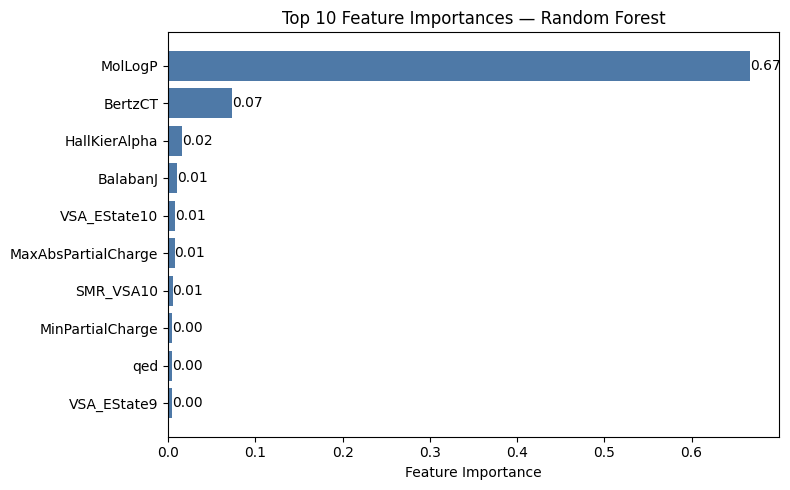

In [29]:
importances = rf.feature_importances_
feature_names = X_train.columns

top_k = 10
indices = np.argsort(importances)[-top_k:][::-1]  # top k, descending
top_features = feature_names[indices]
top_importances = importances[indices]



plt.figure(figsize=(8, 5))
bars = plt.barh(range(top_k), top_importances[::-1], color="#4e79a7")
plt.yticks(range(top_k), top_features[::-1])
plt.xlabel("Feature Importance")
plt.title("Top 10 Feature Importances — Random Forest")
plt.gca()  # highest at top
# Optional: add value labels
for i, v in enumerate(top_importances[::-1]):
    plt.text(v, i, f"{v:.2f}", va="center")
plt.tight_layout()
plt.show()


## Even More Advanced Workflows

When working with ML models, we always have parameters that we have to adjust based on the given data, e.g., for the linear model we adjusted the slope and the y-intercept. When having more complex models there are also so-called hyperparameters, which are the parameters that already define parts of the model, e.g., the number of trees in a random forest. The hyperparameters have to be selected before training, but ideally we would like to select them based on the data. Therefore, we use a method called k-fold CV, where we split the training set into k parts and in each of the k iterations, we use another part for testing and the remaining k-1 parts for training. By this we can already estimate the error on the real test set and make informed decisions without leaking information from the test set.

First, we split the training data into 5 folds for a 5-fold CV.

In [ ]:
e_splits, _, _ = datasail(
    techniques=["C1e"],
    splits=[0.2 for i in range(5)],
    names=[f'fold{i}' for i in range(1,6)],
    runs=3,
    solver="SCIP",
    e_type="M",
    e_data=dict(zip(X_train.index, smiles_df.loc[X_train.index, "SMILES"].values.tolist())),
)
split = e_splits['C1e'][0]

In [ ]:
folds = {}
for sample in split.keys():
    fold = split[sample]
    if not fold in folds.keys():
        folds[fold] = [sample]
    else:
        folds[fold].append(sample)

In [ ]:
best_score = -np.inf
best_trees = None
for n_trees in [200, 500, 700]:
    r2s = []
    for i in range(1,6):
        fold = f'fold{i}'
        test_part = X_train.loc[folds[fold], :]
        train_folds = set(f'fold{j}' for j in range(1,6))
        train_folds.remove(fold)
        train_part_samples = np.concatenate([folds[f] for f in train_folds])
        train_part = X_train.loc[train_part_samples, :]
        train_response = y_train.loc[train_part_samples, :]
        test_response = y_train.loc[folds[fold], :]
        rf = RandomForestRegressor(random_state=42, n_estimators=n_trees, n_jobs=-1)
        rf.fit(train_part, train_response)
        test_predict = rf.predict(test_part)
        r2s.append(r2_score(test_predict, test_response))
    mean_performance = np.mean(r2s)
    print(f'5-fold CV done for #trees = {n_trees}.')
    print(f'Average performance of {mean_performance}.')
    if  mean_performance > best_score:
        best_score = mean_performance
        best_trees = n_trees
print(f'The best number of trees is {best_trees}.')
print(f'The model had on average an R2 of {best_score}.')
rf_final = RandomForestRegressor(random_state=42, n_estimators=best_trees)
rf_final.fit(X_train,y_train)
y_pred = rf_final.predict(X_test)
print('Performance on the test set:')
print(f"Mean absolute error: {mean_absolute_error(y_test, y_pred):.2f}")
print(f"Coefficient of determination: {r2_score(y_test, y_pred):.2f}")